# Notes, 2/8/18

## netCDF4 and HDF5

* Netcdf4 and HDF5 both have the same underlying file structure
    * File structure is called HDF5
* Python Netcdf4
    * Lots of unlimited size dimensions needs careful attention
        * If more than one unlimited dimension, the default chunk size is 1024
            * If this dimension ends up with small size, still have a size of 1024 allocated in the file
            * Lots of wasted file space
        * Unlimited dimensions appear to be detrimental to file size
            * Large reduction in file size can be obtained by minimizing the number of unlimited dimensions
        * Variable compression (zlib=True) slows way down with multiple unlimited dimensions
        * These effects are likely coming from the need to keep rebuilding the variable as the dimension sizes keep changing
            * The data has to be uncompressed and then re-compressed
            * The gross mismatch of chunk sizes likely exacerbates this
                * Both for performance and memory usage
    * Example from jedi_bufr2nc
        * jedi_bufr2nc.py Aircraft ../bufr2nc/test/data/gdas.t00z.prepbufr.nr aircraft.test.nc
        * The input prepbufr file is 49MB
        * When compression (level = 6) was used in jed_bufr2nc.py
            * Default chunk sizing
            * Process took about 20 minutes to run!
            * Output file was about 100MB!
            * A variable with size (1867,1) was using chunk size (1024,1024)
        * Shut off compression (zlib=False)
            * Process much faster --> 2 minutes
            * But output file huge, 1GB!
                * Ridiculous waste, the output data uncompressed should be around 350KB
        * Specified chunksize using a size of 1 for all unlimited dimensions
            * Runtime about the same
            * File size reduced to 86MB
                * Way better, but still excessive waste
        * Used nccopy for two more improvements
            * Change unlimited dims to fixed dims
                * nccopy -u infile outfile
            * Shuffle and compress file (level 6)
                * nccopy -d 6 -s infile outfile
            * Recommended to do these in two distict steps
                * compression works much more effectively when dims are fixed
        * Change unlimited dims to fixed dims
            * Long runtime: 5 - 10 minutes
            * File reduced to 6MB
            * Note: no compress has been applied at this point
        * Shuffle and compress file
            * Very fast, 1 second
            * File reduce to 211KB
                * Much more reasonable
        * Summary of impacts show in sequence the actions were tried
        
| Action | File Size | Var Size | Chunk Size |
|:-------|:---------:|:--------:|:----------:|
|Default chunking|1GB|(1867,1)|(1024,1024)|
|Chunking with size 1 for unlim dims|86MB|(1867,1)|(1,1)|
|Change unlim dims to fixed dims|6MB|(1867,1)|(1867,1)|
|Shuffle and compress|221KB|(1861,1)|(1861,1)|



# Notes, 2/9/18

## jedi_bufr2nc.py

* Cannot directly query the BUFR file (nor BUFR table) to find dimension sizes
* Options for efficiently writing the netCDF file
    * Two passes through the BUFR file
        * Pass1: read all obs and determine dimension sizes
            * Won't work to read a representative obs since number of levels can be different (T vs U example)
        * Pass2: read obs and transfer to the netcdf file
        
        * Pros:
            * Will get dimension sizes set to the minimum necessary per file
            * Can make all netcdf dimensions fixed size
            
        * Cons:
            * Slow to read the BUFR file twice (but not that bad)
            
    * One pass through the BUFR file and post process the netCDF file
        * Create file uncompressed and unlimited dimensions while reading the BUFR file
        * Convert dims to fixed
        * Compress
        
        * Pros: 
            * Save time by only reading BUFR file once
            * Compression may be optimized since the variables are complete before compression starts
                * May not make much difference
        
        * Cons:
            * Slow
                * The "convert dims to fixed" is an especially slow process

    * One pass through the BUFR file and assume max dimensions for the netCDF file
        * Pros:
            * Fastest execution
        
        * Cons:
            * Wastes space
                * Compression may mitigate this since there will be a lot of repeated values


# Notes, 2/12/18

## jedi_bufr2nc.py

* Created srherbener/bufr2nc repository on GitHub
    * jedi_bufr2nc.py script
    * Two Fortran utilities
        * pb_decode.f90: dump out bufr table and obs (ufbint() calls)
        * pb_decode_events.f90: dump out bufr table and events (ufbevn() calls)
* Test case: gdas.t00z.prepbufr.nr
    * Runs in about 30 seconds
    * Input 49MB
    * Output (AIRCFT, AIRCAR) 200KB
        * 18 messages selected
        * 1867 obs recorded
* Xin's file: prepbufr.gdas.20160304.t06z.nr.48h
    * Runs in 1.5 hours
    * Input 62MB
    * Output (AIRCFT, AIRCAR) 4.3MB
        * 2268 messages selected
        * 222316 obs recorded
* Performance is not good, the Fortran programs run a little faster considering the python script makes two passes through the BUFR file.
    * Reading obs from a subset is slow

# Notes, 2/20/18

* I'll be gatekeeper for the IODA repository

* Map containing which list of mnemonics from BUFR go with each obs type should be placed in IODA somewhere
    * One copy
    * All subsystems have access to the list

* Xin
    * Variable names are hard coded in the netCDF readers
    * src/ncdiag
        * m_diag_aircraft.f90 (aircraft)
        * m_diag_conv.f90 (conventional)
        * m_diag_raob.f90 (radiosonde)
    * Don't want to have to write separate fortran files for each obs type since there will be 30-40 of these

# Notes, 2/26/18

* GeoVaLs
    * Column (vertical profile) of model data interpolated to obs location
    * Don't differentiate time points yet
        * This will need to be added


# ncdiag format, 3/12/18

## ioda/src/ncdiag/

* Fortran structures defined in files for different obs types
    * m_diag_conv.f90: conventional obs (radiosonde)
    * m_diag_raob.f90: radiance obs
    * m_diag_aircft.f90: aircraft obs

* Each structure has the same three sections in them
    * header
    * mass (t,p,q)
    * wind (u,v)

* Elements of header section
    * ObsType
    * n_ObsType
    * n_Observations
    * n_Observations_Mass
    * n_Observations_Wind
    * n_Observations_Total
    * date

* Elements of mass section
    * Station_ID
    * Observation_Class
    * Observation_Type
    * Observation_Subtype
    * Latitude
    * Longitude
    * Pressure
    * Height
    * Time
    * Prep_QC_Mark
    * Setup_QC_Mark
    * Prep_Use_flag
    * Analysis_Use_Flag
    * Nonlinear_QC_Rel_Wgt
    * Errinv_Input
    * Errinv_Adjust
    * Errinv_Final
    * Observation
    * Observation_Forecast_adjusted
    * Observation_Forecast_unadjusted

* Elements of wind section (same as mass except for elements near end are exapanded for u and v)
    * Station_ID
    * Observation_Class
    * Observation_Type
    * Observation_Subtype
    * Latitude
    * Longitude
    * Pressure
    * Height
    * Time
    * Prep_QC_Mark
    * Setup_QC_Mark
    * Prep_Use_flag
    * Analysis_Use_Flag
    * Nonlinear_QC_Rel_Wgt
    * Errinv_Input
    * Errinv_Adjust
    * Errinv_Final
    * u_Observation
    * u_Observation_Forecast_adjusted
    * u_Observation_Forecast_unadjusted
    * v_Observation
    * v_Observation_Forecast_adjusted
    * v_Observation_Forecast_unadjusted
    * Wind_Reduction_Factor_at_10m

* Arrays of these structures get loaded up, then written out into netCDF files.
    * Buffering is handled by the ncdiag code
        * Load up a bunch of obs, then write out every once in a while

## Dump of the header of a sample ncdiag file

~~~~~~~~~
8-33:bufr2nc.test stephenh$ ncdump -h ~/projects/data/ncdiag/diag_conv_t_ges.2016010900_control.nc4
netcdf diag_conv_t_ges.2016010900_control {
dimensions:
	nobs = UNLIMITED ; // (201763 currently)
	Station_ID_maxstrlen = 8 ;
	Observation_Class_maxstrlen = 7 ;
	Bias_Correction_Terms_arr_dim = 3 ;
variables:
	char Station_ID(nobs, Station_ID_maxstrlen) ;
	char Observation_Class(nobs, Observation_Class_maxstrlen) ;
	int Observation_Type(nobs) ;
	float Latitude(nobs) ;
	float Longitude(nobs) ;
	float Station_Elevation(nobs) ;
	float Pressure(nobs) ;
	float Height(nobs) ;
	float Time(nobs) ;
	float Prep_QC_Mark(nobs) ;
	float Setup_QC_Mark(nobs) ;
	float Prep_Use_Flag(nobs) ;
	float Analysis_Use_Flag(nobs) ;
	float Nonlinear_QC_Rel_Wgt(nobs) ;
	float Errinv_Input(nobs) ;
	float Errinv_Adjust(nobs) ;
	float Errinv_Final(nobs) ;
	float Observation(nobs) ;
	float Obs_Minus_Forecast_adjusted(nobs) ;
	float Obs_Minus_Forecast_unadjusted(nobs) ;
	float Data_Pof(nobs) ;
	float Bias_Correction_Terms(nobs, Bias_Correction_Terms_arr_dim) ;

// global attributes:
		:Number_of_Predictors = 3 ;
		:date_time = 2016010900 ;
		:Number_of_state_vars = 579 ;
}
8-33:bufr2nc.test stephenh$
~~~~~~~~~

# Meeting with Clara, 5/13/18

* Clara is creating a new Fortran program called something like "read_ncdiag.f90" that will go in the GSI code.
    * Mimics the function of read_prepbufr.f90, but reads ncdiag instead of prepbufr.

## GSI, read_prepbufr.f90

### Utilizes:
* ufbint()
    * Read a non-replicated or delayed-replicated data value
* ufbevn()
    * Read a nested replication sequence in the current subset
    * The inner replication typically are levels
    * The outer replication typically are events
* ufbrep()
    * Read regularly replicated data values
* ufbqcd()
    * Specialized read of nmemonic in current subset
    * QCD -> Quality Control for table D entries
        * NCEP specified codes, for marking prepBUFR processing steps
    * FXY code where F = 3 and X = 63 (ie, 363YYY)
        * Eg, 363008 (Y=008) is VIRTMP

### Defines strings that are used for calling ufb\* routines
~~~~~~~~~
!  data statements
  data hdstr  /'SID XOB YOB DHR TYP ELV SAID T29'/
  data hdstr2 /'TYP SAID T29 SID'/
  data obstr  /'POB QOB TOB ZOB UOB VOB PWO MXGS HOVI CAT PRSS TDO PMO' /
  data drift  /'XDR YDR HRDR                    '/
  data sststr /'MSST DBSS SST1 SSTQM SSTOE           '/
  data qcstr  /'PQM QQM TQM ZQM WQM NUL PWQ PMQ'/
  data oestr  /'POE QOE TOE NUL WOE NUL PWE     '/
! data satqcstr  /'RFFL QIFY QIFN EEQF'/
  data satqcstr  /'QIFN'/
  data prvstr /'PRVSTG'/   
  data sprvstr /'SPRVSTG'/ 
  data levstr  /'POB'/
  data cld2seqstr /'TOCC HBLCS'/      ! total cloud cover and height above surface of base of lowest cloud seen
  data cldseqstr /'VSSO CLAM HOCB'/   ! vertical significance, cloud amount and cloud base height
  data metarcldstr /'CLAM HOCB'/      ! cloud amount and cloud base height
  data metarwthstr /'PRWE'/           ! present weather
  data metarvisstr /'HOVI TDO'/       ! visibility and dew point
  data goescldstr /'CDTP TOCC GCDTT CDTP_QM'/   ! NESDIS cloud products: cloud top pressure, total cloud amount,
                                                !   cloud top temperature, cloud top temp. qc mark
  data aircraftstr /'POAF IALR'/      ! phase of aircraft flight and vertical velocity
  data maxtmintstr  /'MXTM MITM'/
  data owavestr  /'HOWV'/
  data cldceilhstr /'CEILING'/
~~~~~~~~~

### ufbint() calls:

~~~~~~~~~
ufbint(lunin,aircraftwk,2,255,levs,aircraftstr)
ufbint(lunin,cldceilh,1,255,levs,cldceilhstr)
ufbint(lunin,cldseq,3,10,cldseqlevs,cldseqstr)
ufbint(lunin,drfdat,8,255,iret,drift)
ufbint(lunin,fcstdat,3,255,levs,'UFC VFC TFC ')
ufbint(lunin,goescld,4,1,levs,goescldstr)
ufbint(lunin,hdr,1,1,iret,'ACID')
ufbint(lunin,hdr,4,1,iret,hdstr2)
ufbint(lunin,hdr,8,1,iret,hdstr)
ufbint(lunin,hdr3,3,255,levs,'XDR YDR HRDR')
ufbint(lunin,hdrtsb,1,1,iret,'TSB')
ufbint(lunin,levdat,1,255,levs,levstr)
ufbint(lunin,maxtmint,2,255,levs,maxtmintstr)
ufbint(lunin,metarcld,2,10,metarcldlevs,metarcldstr)
ufbint(lunin,metarvis,2,1,iret,metarvisstr)
ufbint(lunin,metarwth,1,10,metarwthlevs,metarwthstr)
ufbint(lunin,obsdat,13,255,levs,obstr)
ufbint(lunin,obserr,8,255,levs,oestr)
ufbint(lunin,owave,1,255,levs,owavestr)
ufbint(lunin,qcmark,8,255,levs,qcstr)
ufbint(lunin,r_prvstg,1,1,iret,prvstr)
ufbint(lunin,r_sprvstg,1,1,iret,sprvstr)
ufbint(lunin,satqc,1,1,iret,satqcstr)
ufbint(lunin,sstdat,8,1,levs,sststr)
~~~~~~~~~

### ufbevn() calls:

~~~~~~~~
ufbevn(lunin,tobaux,2,255,20,levs,'TOB TQM')
ufbevn(lunin,tpc,1,255,20,levs,'TPC')
~~~~~~~~

### ufbrep() calls:

~~~~~~~~
ufbrep(lunin,cld2seq,2,1,cld2seqlevs,cld2seqstr)
~~~~~~~~

### ufbqcd() calls:

~~~~~~~~
ufbqcd(lunin,'VIRTMP',vtcd)
~~~~~~~~

### General idea

* The bufr2nc.py script needs to support the creation of the same sets of data that GSI read_prepbufr.f90 is handling
* Since read_ncdiag.f90 is mimicing read_prepbufr.f90, the bufr2nc.py script needs to use the same mnemonic strings
* It would be useful for both bufr2nc.py and read_ncdiag.f90 to read a single config file that defines the mnemonic strings
    * Use Fortran namelist format
        * Fortran can read directly
        * Python has a namelist reader
* Don't use nan for missing float (Clara has script changes)
* Leave empty values in the ncdiag file for now
    * Define 255 levels, only use 100 levels, leave the unused levels empty


# Notes, 3/15/18

## Target flow for UFO/GSI using ncdiag

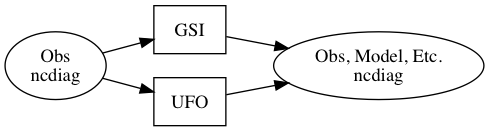



# Notes, 3/23/18

* Apparently, the IODA ncdiag reader/writer was created from an older copy of the GSI ncdiag reader/writer
    * Hopefully, this means that merging the two reader/writers will be easier

## UFO's usage of the IODA ncdiag reader/writer

* Reader and writer are used

* Different obs types use different modules in IODA

* The newer style appears to be the one where m_diag_obstype.F90 is used
    * This is stripped down from read_diag.f90

* read_diag.f90
    * has capability to read the old binary diag format and the new netcdf diag format

* Objects in UFO are created from BasicObsData class and extended with ncdiag fortran structures
    * The ncdiag reader is called to fill in the ncdiag structures

### ufo/src/ufo/radDiag_mod.F90

* Uses read_diag.f90 module from IODA source
    * read_radiag_header(ftin,npred_radiag,retrieval,header_fix,header_chan,data_name,iflag,lverbose)
    * read_radiag_data(ftin,header_fix,retrieval,data_fix,data_chan,data_extra,iflag )

* Calls
    * set_netcdf_read(.true.)
    * read_radiag_header(luin,npred,retrieval,self%header_fix,self%header_chan,self%header_name,ier,lverbose)
    * read_all_radiag(luin, self%header_fix, retrieval, self%datafix, self%datachan, self%dataextra, nobs, ier)

### ufo/src/ufo/roabDiag_mod.F90

* Uses m_diag_raob.f90 module from IODA source
    * write_split_raob_diag_nc(infn,raob_header, raob_mass, raob_wind, append_suffix)
    * read_raob_diag_nc_header(infn,raob_header)
    * read_raob_diag_nc_mass(infn, raob_header, raob_mass, ierr)

* Calls
    * read_raob_diag_nc_header(filein,self%header)
    * read_raob_diag_nc_mass(filein,self%header,self%mass,ier)

### ufo/src/ufo/aircftDiag_mod.F90

* Uses m_diag_aircrf.f90 module from IODA source
    * write_split_aircft_diag_nc(infn,aircft_header, aircft_mass, aircft_wind, append_suffix)
    * read_aircft_diag_nc_header(infn,aircft_header)
    * read_aircft_diag_nc_mass(infn, aircft_header, aircft_mass, wbgn, wend, ierr)

* Calls
    * read_aircft_diag_nc_header(filein,self%header)
    * read_aircft_diag_nc_mass(filein,self%header,self%mass,wbgn,wend,ier)
    

### ufo/src/ufo/ufo_geovals_mod.F90

* Uses nc_diag_read_mod.f90 from IODA source

* Calls
    * nc_diag_read_init(filename, iunit)
    * nc_diag_read_get_dim(iunit,'nobs')
    * nc_diag_read_check_var(iunit, vars%fldnames(ivar))
    * nc_diag_read_get_var_dims(iunit, vars%fldnames(ivar), nvardim, vardims)
    * nc_diag_read_get_var_type(iunit, vars%fldnames(ivar))
    * nc_diag_read_get_var(iunit, vars%fldnames(ivar), fieldr1d)
    * nc_diag_read_close(filename)

### ufo/src/ufo/ufo_obs_seaicefrac_mod.F90

* Uses nc_diag_read_mod.f90 from IODA source

* Calls
    * nc_diag_read_init(filename, iunit)
    * nc_diag_read_get_dim(iunit,'Rows')  
      ...
    * nc_diag_read_get_var(iunit, "Latitude", field)  
      ...
    * nc_diag_read_close(filename)


# Meeting with Clara, 3/29/18

* AMSU-A is a subset of "tovs"

* GPSRO and AMSU-A are raw BUFR formats

## Timestamps in the ncdiag file

* All of the raw BUFR formats need to calculate a reference time and a time offset
    * For window selection downstream
    * Data shows up every 0, 6, 12 and 18Z
        * These times (0, 6, 12, 18Z) are called analysis times
    * raw BUFR gives YEAR, MNTH, DAYS, HOUR, MINU, SECO
        * Take these values and calculate offset from the reference time
    * Reference time is calculated:
        * Find earliest time from all selected messages (msg_date values)
        * From the earliest time, move forward to the next analysis time (0, 6, 12, 18Z)
            * This analysis time becomes the reference time
    * Store the reference time in an attribute
        * Same reference time for all subsets
    * Store offset time in variable

* prepBUFR already does the reference/offset time scheme
    * Make prepBUFR output match that of raw BUFR
        * Reference time goes into the same named attribute
        * Offset time goes into the same named variable

* Store reference time in hours
    * Time values end with hours which is one of: 0, 6, 12, 18Z

* Store offset time in seconds

* Jeff's gpsbufr2nc.py is almost what we want
    * The reference time is stored as the units on the variable "Time"
        * Units: "seconds since YYYYMMDD HH:00 UTS"
            * The reference time is stored in the YYYYMMDD HH:00 part
    * The offset time is stored as the values of the variable "Time"
    
    * Don't use the netcdf variable names from gpsbufr2nc.py
        * Use the older (mnemonic) names

* Once completed, we should be able to get rid of storing msg_date


# Meeting with Yannick, 3/29/18

* Now have 5 obs types
    * Aircraft
    * AOD
    * Radiance (AMSU-A)
    * Radiosonde
    * GPSRO

* Moving forward
    * Don't add anymore obs types
    * Get the code streamlined with these 5 obs types
        * Converge ncdiag reader/writers
        * Make it easy, efficient to add an obs type
            * Currently, to add an obs type, the developer will cut-and-paste code for an existing one
                * Creates lots of duplicated code
                * We have diverged into two methods
                    * read_diag.f90, read_aod_diag.f90 --> radiance and AOD obs types
                    * m_diag_aircft.f90, m_diag_raob.f90 --> aircraft and radiosonde obs types
                    * Not sure where GPSRO will land (could be a third type)
            * Put obs types into classes (OO approach)
                * Eliminate redundant code
                * Much easier to maintain
       * Once adding an obs type is efficient, document how this is done


# Notes, 4/3/18

## Steps to move ioda repo from UCAR to JCSDA

* Make clone from UCAR/ioda
* Change remote to JCSDA/ioda
* Push
* Go through all bundle repos and change CMakeLists.txt to reference JCSDA/ioda

* Coordinate with developers
    * Check who owns feature branches in ioda
    * Send emails to everyone asking to push their work and wait for the move
    * Send email when move is completed asking to switch to JCSDA/ioda

## Steps for completing Xin's pull request and moving ioda repo

* Xin: Merge develop into feature/aircraft
* Xin: Issue pull request for ioda and ufo repos
* Steve,Yannick: Review, merge pull requests
* Steve: move ioda repo from UCAR to JCSDA

## Xin's task to add multiple obs for Aircraft

* Xin is held up due to limitation in ioda ncdiag files and reader
* Need to merge GSI and UFO ncdiag readers
* Should use a standard naming convention for ncdiag
    * Gives access to 3rd party software (plotters perhaps?)
    * CF is a candidate
        * Climate/Forecast metadata standard: http://cfconventions.org/index.html  
* For expediency, Clara is using the BUFR mnemonics for the ncdiag naming convention
    * Convert to standard convention after flow is enabled
* Xin has another task he can work on while the ioda ncdiag reader/writer is fixed

## Steps to fix ioda ncdiag reader/writer and enable multiple Aircraft obs

* Adopt BUFR naming convention for now
* Merge UFO/GSI ncdiag readers/writers
* Create interface that encapsulates what's stored in the file
* Change file to standard naming convention later

## Discussion with Xin

* May need to provide both netcdf and odb as file storage options
    * Some collaborators (universities) may be reluctant to use ODB because it takes up a lot of space
        * How much space does ODB consume?
    * If this is a problem, providing netcdf as an option could be a way to address this
        * This would speak to the objective of making JEDI easy to use

# CF conventions

* CF is a metadata spec that can be used in netcdf  
    http://cfconventions.org/index.html  
    * Articles  
        https://www.earthcube.org/group/advancing-netcdf-cf  
        https://earthdata.nasa.gov/user-resources/standards-and-references/climate-and-forecast-cf-metadata-conventions  
        http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-20010629.htm

* CFA is for aggregated fields in CF format  
    http://www.met.reading.ac.uk/~david/cfa/0.4/

* Python interface
    * cf-python  
        https://cfpython.bitbucket.io/  
        * Looks mature
        * Great documenation  
            https://cfpython.bitbucket.io/docs/latest/a_first_example.html  
        * cf-plot
            * Can plot netCDF CF fields
    * pynetCF  
        https://github.com/TUW-GEO/pynetCF  
        * Does not look as mature as cf-python

* C/Fortran interface
    * UCAR has a library for netCDF CF  
        https://www.unidata.ucar.edu/software/nccflib/  
        * C and Fortran
        * Looks like it was abandoned a number of years ago
    